In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import random

In [3]:
metadata = pd.read_csv("HAM10000_metadata.csv")

In [4]:
images = np.loadtxt('hnmist_28_28_RGB.csv', delimiter=',', skiprows=1)
num_images = images.shape[0]
images = images.reshape((num_images, 28, 28, 3))
images = images / 255.0

In [4]:
metadata[metadata["dx"]=="nv"].head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
64,HAM_0001751,ISIC_0024698,nv,consensus,70.0,male,face
1210,HAM_0000559,ISIC_0024693,nv,follow_up,45.0,female,upper extremity
2976,HAM_0004932,ISIC_0032212,nv,follow_up,45.0,female,foot
2977,HAM_0004516,ISIC_0025775,nv,follow_up,45.0,female,neck
2978,HAM_0006510,ISIC_0029828,nv,follow_up,55.0,female,lower extremity


In [5]:
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
# Ver porcentaje de cada clase
porcentajes = metadata['dx'].value_counts(normalize=True) * 100

# Mostrar redondeado
print(porcentajes.round(2))

dx
nv       66.95
mel      11.11
bkl      10.97
bcc       5.13
akiec     3.27
vasc      1.42
df        1.15
Name: proportion, dtype: float64


In [6]:
print("metadata size: " + str(metadata.shape[0]))
print("hnmist size: " + str(num_images))

metadata size: 10015
hnmist size: 10015


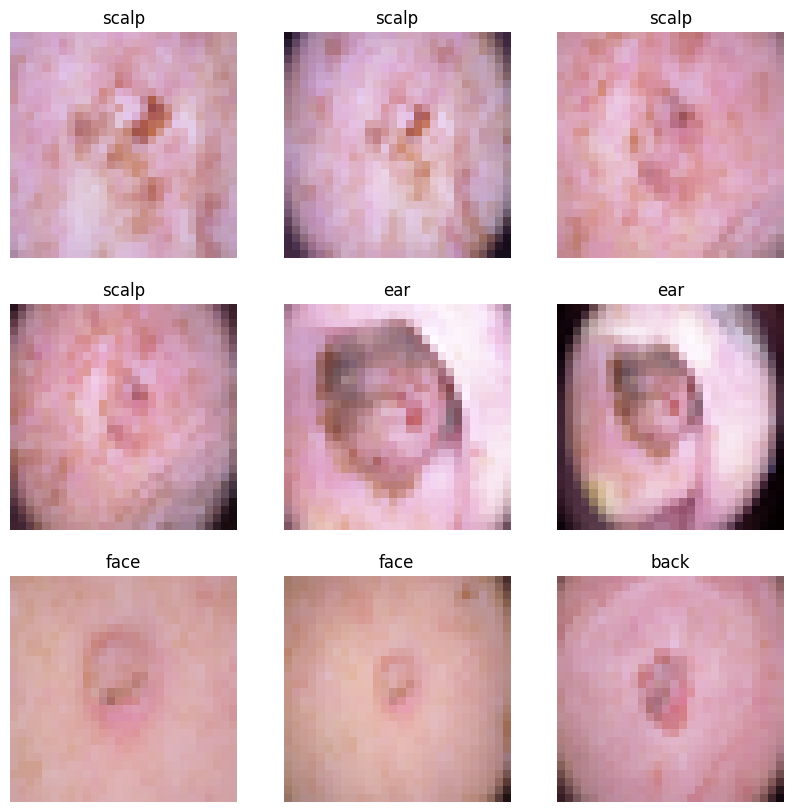

In [6]:
# Visualizar datos
num_to_show = 9

plt.figure(figsize=(10,10))
for i in range(num_to_show):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    localizacion = metadata.iloc[i]['localization']
    plt.title(f"{localizacion}")
    plt.axis("off")
plt.show()

Cantidad disponible para 'bkl': 1099


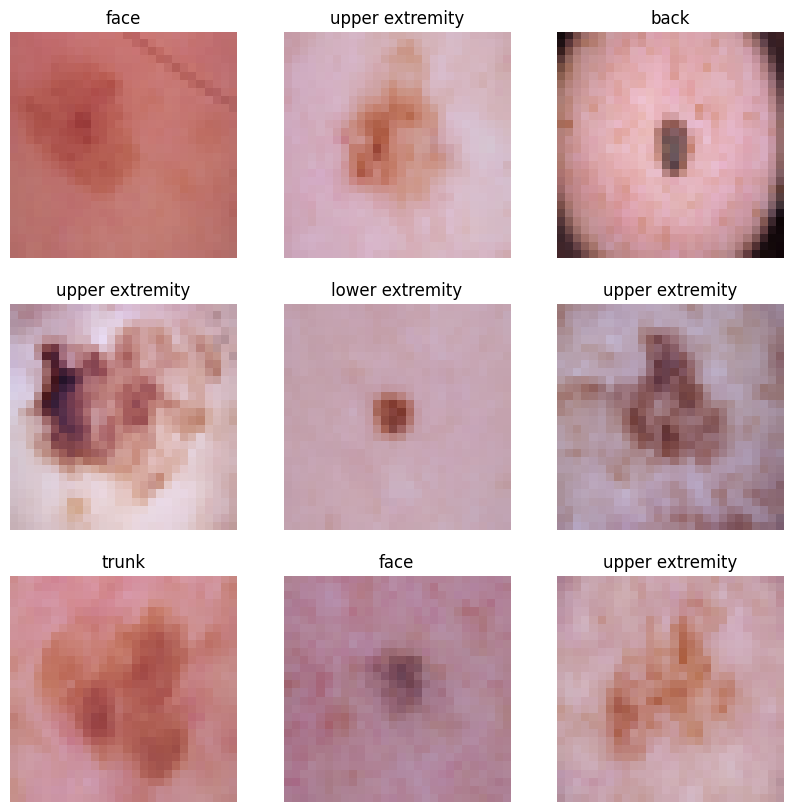

In [7]:
filtro_loc = 'bkl'
subset = metadata[metadata['dx'] == filtro_loc]
indices_filtrados = subset.index.tolist()
print(f"Cantidad disponible para '{filtro_loc}':", len(indices_filtrados))

num_to_show = min(9, len(indices_filtrados))
indices_muestra = random.sample(indices_filtrados, num_to_show)

plt.figure(figsize=(10,10))
for i in range(num_to_show):
    idx = indices_muestra[i]
    plt.subplot(3, 3, i+1)
    plt.imshow(images[idx])
    localizacion = metadata.iloc[idx]['localization']
    plt.title(f"{localizacion}")
    plt.axis("off")
plt.show()


In [9]:
# Seleccionar columnas relevantes
df_tab = metadata[['age', 'sex', 'localization', 'dx']].dropna()

images_filtradas = images[df_tab.index]
print(images_filtradas.shape)

# Codificar variables categóricas
le_sex = LabelEncoder()
le_loc = LabelEncoder()
le_dx = LabelEncoder()

(9958, 28, 28, 3)


In [10]:
df_tab['sex'] = le_sex.fit_transform(df_tab['sex'])
df_tab['localization'] = le_loc.fit_transform(df_tab['localization'])
df_tab['dx'] = le_dx.fit_transform(df_tab['dx'])

In [11]:
# Inputs y labels
X_tab = df_tab[['age', 'sex', 'localization']].values
y = df_tab['dx'].values

In [12]:
# Normalizar
scaler = StandardScaler()
X_tab_scaled = scaler.fit_transform(X_tab)

In [13]:
# One-hot para las etiquetas
y_cat = to_categorical(y)

In [14]:
# División estratificada
train_idx, temp_idx, y_train_raw, y_temp_raw = train_test_split(
    np.arange(len(X_tab_scaled)), y_cat, test_size=0.3, random_state=42, stratify=y_cat
)
val_idx, test_idx, y_val_raw, y_test_raw = train_test_split(
    temp_idx, y_cat[temp_idx], test_size=0.5, random_state=42, stratify=y_cat[temp_idx]
)

# Extraer datos
X_train = X_tab_scaled[train_idx]
X_val   = X_tab_scaled[val_idx]
X_test  = X_tab_scaled[test_idx]

y_train = y_cat[train_idx]
y_val   = y_cat[val_idx]
y_test  = y_cat[test_idx]


In [28]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Convertir etiquetas de one-hot a enteros
y_train_labels = np.argmax(y_train, axis=1)

# Calcular pesos de clase balanceados
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)

# Pasarlo a diccionario {0: peso_clase_0, 1: peso_clase_1, ...}
class_weights_dict = dict(enumerate(class_weights))

# Mostrar los pesos calculados
print("Pesos de clase:", class_weights_dict)


Pesos de clase: {0: 4.348097317529632, 1: 2.765873015873016, 2: 1.3067116610423697, 3: 12.446428571428571, 4: 1.279838413514506, 5: 0.21358092786664215, 6: 10.057720057720058}


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Arquitectura simple para datos tabulares
input_tab = Input(shape=(X_train.shape[1],))
x = Dense(64, activation='relu')(input_tab)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
output = Dense(y_cat.shape[1], activation='softmax')(x)

model_tab = Model(inputs=input_tab, outputs=output)
model_tab.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento con pesos de clase
history_tab_w = model_tab.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=32,
    shuffle=True,
    # class_weight=class_weights_dict,
    # callbacks=[early_stop]
)



Epoch 1/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2808 - loss: 2.0014 - val_accuracy: 0.5395 - val_loss: 1.7195
Epoch 2/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3895 - loss: 1.8098 - val_accuracy: 0.4726 - val_loss: 1.6869
Epoch 3/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3089 - loss: 1.7912 - val_accuracy: 0.1493 - val_loss: 1.7397
Epoch 4/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2323 - loss: 1.7752 - val_accuracy: 0.3976 - val_loss: 1.6238
Epoch 5/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3430 - loss: 1.7574 - val_accuracy: 0.1359 - val_loss: 1.7272
Epoch 6/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1987 - loss: 1.7639 - val_accuracy: 0.2115 - val_loss: 1.6639
Epoch 7/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2743 - loss: 1.6856 - val_accuracy: 0.1573 - val_loss: 1.7082
Epoch 8/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2096 - loss: 1.7633 - val_accuracy: 0.

In [30]:
loss, acc = model_tab.evaluate(X_test, y_test)
print(f"Precisión en test (modelo 1D tabular): {acc:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2552 - loss: 1.6853
Precisión en test (modelo 1D tabular): 0.2651


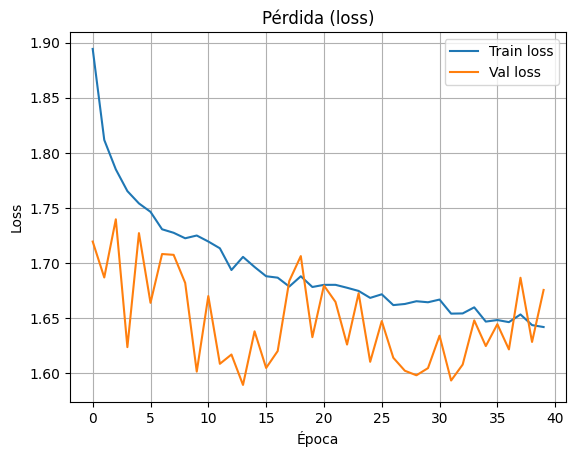

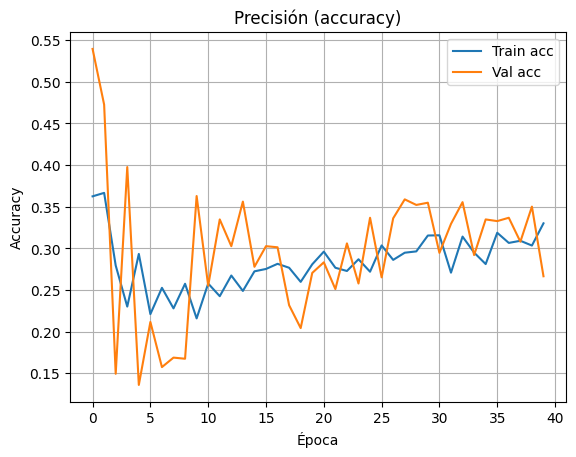

In [32]:
import matplotlib.pyplot as plt

# Curva de pérdida
plt.plot(history_tab_w.history['loss'], label='Train loss')
plt.plot(history_tab_w.history['val_loss'], label='Val loss')
plt.title('Pérdida (loss)')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Curva de precisión
plt.plot(history_tab_w.history['accuracy'], label='Train acc')
plt.plot(history_tab_w.history['val_accuracy'], label='Val acc')
plt.title('Precisión (accuracy)')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


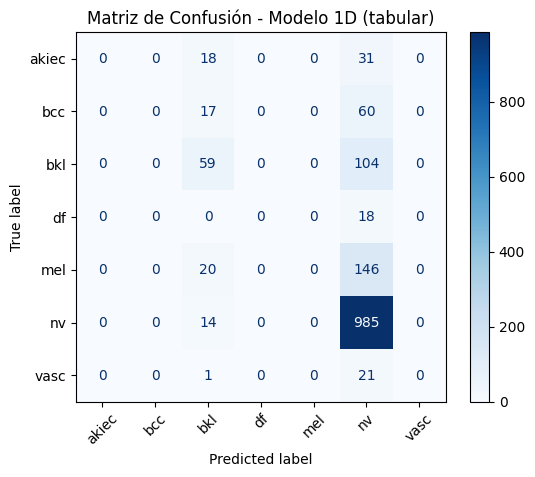

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        49
         bcc       0.00      0.00      0.00        77
         bkl       0.46      0.36      0.40       163
          df       0.00      0.00      0.00        18
         mel       0.00      0.00      0.00       166
          nv       0.72      0.99      0.83       999
        vasc       0.00      0.00      0.00        22

    accuracy                           0.70      1494
   macro avg       0.17      0.19      0.18      1494
weighted avg       0.53      0.70      0.60      1494



c:\Users\yordy\Documents\dev\bootcamp\inteligencia_artificial\keepcoding\deep-learning-keepcoding\env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\yordy\Documents\dev\bootcamp\inteligencia_artificial\keepcoding\deep-learning-keepcoding\env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\yordy\Documents\dev\bootcamp\inteligencia_artificial\keepcoding\deep-learning-keepcoding\env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-d

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np

# Predicciones del modelo 1D
y_pred_tab = np.argmax(model_tab.predict(X_test), axis=1)
y_true_tab = np.argmax(y_test, axis=1)

# Matriz de confusión
cm = confusion_matrix(y_true_tab, y_pred_tab)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_dx.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de Confusión - Modelo 1D (tabular)")
plt.show()

# Reporte por clase
print(classification_report(y_true_tab, y_pred_tab, target_names=le_dx.classes_))



47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


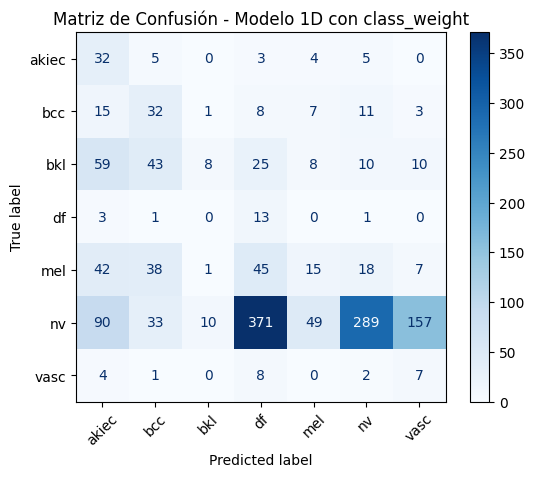

              precision    recall  f1-score   support

       akiec       0.13      0.65      0.22        49
         bcc       0.21      0.42      0.28        77
         bkl       0.40      0.05      0.09       163
          df       0.03      0.72      0.05        18
         mel       0.18      0.09      0.12       166
          nv       0.86      0.29      0.43       999
        vasc       0.04      0.32      0.07        22

    accuracy                           0.27      1494
   macro avg       0.26      0.36      0.18      1494
weighted avg       0.65      0.27      0.34      1494



In [33]:
# Predicciones y etiquetas verdaderas
y_pred_w = np.argmax(model_tab.predict(X_test), axis=1)
y_true_w = np.argmax(y_test, axis=1)

# Matriz de confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

cm_w = confusion_matrix(y_true_w, y_pred_w)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_w, display_labels=le_dx.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de Confusión - Modelo 1D con class_weight")
plt.show()

# Reporte detallado
print(classification_report(y_true_w, y_pred_w, target_names=le_dx.classes_))


In [17]:
nuevo_paciente = {
    'age': 70,
    'sex': 'male',
    'localization': 'ear'
}

In [18]:
# Codificar sexo y localización
sex_cod = le_sex.transform([nuevo_paciente['sex']])[0]
loc_cod = le_loc.transform([nuevo_paciente['localization']])[0]

# Crear array con los tres valores
X_nuevo = np.array([[nuevo_paciente['age'], sex_cod, loc_cod]])

# Escalar como antes
X_nuevo_scaled = scaler.transform(X_nuevo)

In [19]:
# Predecir
pred_probs = model_tab.predict(X_nuevo_scaled)
pred_clase = np.argmax(pred_probs)
clase_nombre = le_dx.inverse_transform([pred_clase])[0]

print("Diagnóstico predicho:", clase_nombre)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Diagnóstico predicho: bkl


In [20]:
print("Imágenes:", images_filtradas.shape)
print("Etiquetas:", y_cat.shape)

Imágenes: (9958, 28, 28, 3)
Etiquetas: (9958, 7)


In [21]:
from sklearn.model_selection import train_test_split
import numpy as np

# Crear índices
indices = np.arange(len(images_filtradas))

# División train (70%) y temp (30%)
train_idx, temp_idx, _, y_temp = train_test_split(
    indices, y_cat, test_size=0.3, random_state=42, stratify=y_cat
)

# División de temp en val (15%) y test (15%)
val_idx, test_idx, _, _ = train_test_split(
    temp_idx, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# División de imágenes y etiquetas
X_img_train = images_filtradas[train_idx]
X_img_val   = images_filtradas[val_idx]
X_img_test  = images_filtradas[test_idx]

y_train = y_cat[train_idx]
y_val   = y_cat[val_idx]
y_test  = y_cat[test_idx]

print("Train:", X_img_train.shape)
print("Val:  ", X_img_val.shape)
print("Test: ", X_img_test.shape)


Train: (6970, 28, 28, 3)
Val:   (1494, 28, 28, 3)
Test:  (1494, 28, 28, 3)


In [22]:
# Guarda los índices para reutilizar
split_indices = {
    "train": train_idx,
    "val": val_idx,
    "test": test_idx
}


In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout

input_img = Input(shape=(28, 28, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(y_cat.shape[1], activation='softmax')(x)

model_img = Model(inputs=input_img, outputs=output)
model_img.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_img.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,735 (944.28 KB)

 Trainable params: 241,735 (944.28 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history_img = model_img.fit(
    X_img_train, y_train,
    validation_data=(X_img_val, y_val),
    epochs=20,
    batch_size=32
)


Epoch 1/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.6509 - loss: 1.1475 - val_accuracy: 0.6794 - val_loss: 0.9403
Epoch 2/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6689 - loss: 0.9335 - val_accuracy: 0.6693 - val_loss: 0.8892
Epoch 3/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6847 - loss: 0.8610 - val_accuracy: 0.6968 - val_loss: 0.8335
Epoch 4/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6978 - loss: 0.8242 - val_accuracy: 0.7082 - val_loss: 0.8088
Epoch 5/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6994 - loss: 0.7962 - val_accuracy: 0.7276 - val_loss: 0.7691
Epoch 6/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7313 - loss: 0.7438 - val_accuracy: 0.7189 - val_loss: 0.7459
Epoch 7/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7214 - loss: 0.7336 - val_accuracy: 0.7396 - val_loss: 0.7090
Epoch 8/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7444 - loss: 0.6814 - val_accu

In [25]:
loss, acc = model_img.evaluate(X_img_test, y_test)
print(f"Precisión en test (modelo 2D con CNN): {acc:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7510 - loss: 0.7473
Precisión en test (modelo 2D con CNN): 0.7617


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


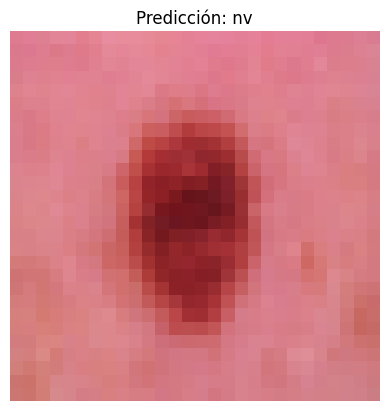

In [26]:
# Imagen en la posición 2 del conjunto de test
id = 5
imagen = X_img_test[id:id+1]  # Importante usar slicing para mantener forma (1, 28, 28, 3)

# Hacer predicción
pred_probs = model_img.predict(imagen)
pred_clase = np.argmax(pred_probs)
clase_nombre = le_dx.inverse_transform([pred_clase])[0]

import matplotlib.pyplot as plt

plt.imshow(X_img_test[id])
plt.title(f"Predicción: {clase_nombre}")
plt.axis("off")
plt.show()



In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

# 1. Predicciones individuales de cada modelo
pred_tab = model_tab.predict(X_test)      # salidas softmax del modelo 1D
pred_img = model_img.predict(X_img_test)      # salidas softmax del modelo 2D

# 2. Fusión: promedio de las probabilidades
pred_late = (pred_tab + pred_img) / 2.0

# 3. Predicción final (clase con mayor probabilidad)
y_pred_late = np.argmax(pred_late, axis=1)
y_true = np.argmax(y_test, axis=1)

# 4. Evaluar precisión
acc_late = accuracy_score(y_true, y_pred_late)
print(f"Precisión (Late-Fusion): {acc_late:.4f}")


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Precisión (Late-Fusion): 0.7631


In [27]:
from tensorflow.keras.models import Model

# Extraer capa antes del softmax (última capa densa antes de output)
model_tab_features = Model(inputs=model_tab.input, outputs=model_tab.layers[-2].output)
model_img_features = Model(inputs=model_img.input, outputs=model_img.layers[-2].output)

# Extraer features del set completo
feat_tab_train = model_tab_features.predict(X_train)
feat_tab_val   = model_tab_features.predict(X_val)
feat_tab_test  = model_tab_features.predict(X_test)

feat_img_train = model_img_features.predict(X_img_train)
feat_img_val   = model_img_features.predict(X_img_val)
feat_img_test  = model_img_features.predict(X_img_test)

# Concatenar features
X_fusion_train = np.concatenate([feat_tab_train, feat_img_train], axis=1)
X_fusion_val   = np.concatenate([feat_tab_val,   feat_img_val], axis=1)
X_fusion_test  = np.concatenate([feat_tab_test,  feat_img_test], axis=1)


218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [28]:
from tensorflow.keras.layers import Input, Dense, Dropout

input_fusion = Input(shape=(X_fusion_train.shape[1],))
x = Dense(64, activation='relu')(input_fusion)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
output = Dense(y_cat.shape[1], activation='softmax')(x)

model_fusion = Model(inputs=input_fusion, outputs=output)
model_fusion.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar sobre features fusionadas
history_fusion = model_fusion.fit(
    X_fusion_train, y_train,
    validation_data=(X_fusion_val, y_val),
    epochs=20,
    batch_size=32
)


Epoch 1/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6496 - loss: 0.9678 - val_accuracy: 0.7798 - val_loss: 0.6217
Epoch 2/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8224 - loss: 0.4730 - val_accuracy: 0.7718 - val_loss: 0.6309
Epoch 3/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8339 - loss: 0.4332 - val_accuracy: 0.7858 - val_loss: 0.6309
Epoch 4/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8420 - loss: 0.4252 - val_accuracy: 0.7965 - val_loss: 0.6427
Epoch 5/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8469 - loss: 0.4084 - val_accuracy: 0.7878 - val_loss: 0.6315
Epoch 6/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8539 - loss: 0.3950 - val_accuracy: 0.7898 - val_loss: 0.6460
Epoch 7/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8658 - loss: 0.3717 - val_accuracy: 0.7805 - val_loss: 0.6678
Epoch 8/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8634 - loss: 0.3602 - val_accuracy: 0.

In [29]:
from sklearn.metrics import accuracy_score

# Evaluación
loss, acc = model_fusion.evaluate(X_fusion_test, y_test)
print(f"Precisión (Early-Fusion): {acc:.4f}")


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7721 - loss: 0.7376 
Precisión (Early-Fusion): 0.7858


In [30]:
y_pred_early = np.argmax(model_fusion.predict(X_fusion_test), axis=1)
y_true = np.argmax(y_test, axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_early, target_names=le_dx.classes_))


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
              precision    recall  f1-score   support

       akiec       0.41      0.37      0.39        49
         bcc       0.60      0.55      0.57        77
         bkl       0.56      0.43      0.49       163
          df       0.40      0.22      0.29        18
         mel       0.50      0.59      0.54       166
          nv       0.90      0.93      0.91       999
        vasc       0.80      0.73      0.76        22

    accuracy                           0.79      1494
   macro avg       0.60      0.54      0.56      1494
weighted avg       0.78      0.79      0.78      1494

